# LDDMM image 3d numpy
For the puproses of double checking, I"m going to reproduce the previous tensorflow notebook exactly in numpy.

## import required libraries

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion() # for drawing in real time
import nibabel as nib

## load images to register

In [2]:
# input image filenames here
# we will deform the atlas to match the target
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [3]:
# load them
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [4]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]

In [5]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]

In [6]:
# simple function for drawing 3 slices
def draw_slices(x,I,axlist,**kwargs):
    ''' Draw three slices through the middle of an image'''
    h0 = axlist[0].imshow(np.squeeze(I[:,:,I.shape[2]//2]),**kwargs)
    h1 = axlist[1].imshow(np.squeeze(I[:,I.shape[1]//2,:]),**kwargs)
    h2 = axlist[2].imshow(np.squeeze(I[I.shape[0]//2,:,:]),**kwargs)
    return [h0,h1,h2]

In [7]:
# draw my images
f,ax = plt.subplots(2,3)
h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
plt.colorbar(mappable=h[-1],ax=ax[0][-1])
h = draw_slices(x,J,ax[1],aspect='equal',cmap='gray')
plt.colorbar(mappable=h[-1],ax=ax[1][-1])

<IPython.core.display.Javascript object>

## Now let's define a linear interpolation function the same way as I did with tensorflow

In [8]:
def interp3(x0,x1,x2,I,phi0,phi1,phi2):
    ''' 
    Linear interpolation
    Interpolate a 3D image I
    with voxels corresponding to locations in x0, x1, x2 (1d arrays)
    at the points phi0, phi1, phi2 (3d arrays)
    '''
    # get the size
    dx = [x0[1]-x0[0], x1[1]-x1[0], x2[1]-x2[0]]
    nx = [len(x0), len(x1), len(x2)]
    #convert to index
    phi0_index = (phi0 - x0[0])/dx[0]
    phi1_index = (phi1 - x1[0])/dx[1]
    phi2_index = (phi2 - x2[0])/dx[2]
    # take the floor to get integers
    phi0_index_floor = np.floor(phi0_index)
    phi1_index_floor = np.floor(phi1_index)
    phi2_index_floor = np.floor(phi2_index)
    # get the fraction to the next pixel
    phi0_p = phi0_index - phi0_index_floor
    phi1_p = phi1_index - phi1_index_floor
    phi2_p = phi2_index - phi2_index_floor
    # get the next samples
    phi0_index_floor_1 = phi0_index_floor+1
    phi1_index_floor_1 = phi1_index_floor+1
    phi2_index_floor_1 = phi2_index_floor+1
    # and apply boundary conditions
    phi0_index_floor = np.minimum(phi0_index_floor,nx[0]-1)
    phi0_index_floor = np.maximum(phi0_index_floor,0)
    phi0_index_floor_1 = np.minimum(phi0_index_floor_1,nx[0]-1)
    phi0_index_floor_1 = np.maximum(phi0_index_floor_1,0)
    phi1_index_floor = np.minimum(phi1_index_floor,nx[1]-1)
    phi1_index_floor = np.maximum(phi1_index_floor,0)
    phi1_index_floor_1 = np.minimum(phi1_index_floor_1,nx[1]-1)
    phi1_index_floor_1 = np.maximum(phi1_index_floor_1,0)
    phi2_index_floor = np.minimum(phi2_index_floor,nx[2]-1)
    phi2_index_floor = np.maximum(phi2_index_floor,0)
    phi2_index_floor_1 = np.minimum(phi2_index_floor_1,nx[2]-1)
    phi2_index_floor_1 = np.maximum(phi2_index_floor_1,0)
    # then we will need to vectorize everything to use scalar indices
    phi0_index_floor_flat = np.reshape(phi0_index_floor,[-1])
    phi0_index_floor_flat_1 = np.reshape(phi0_index_floor_1,[-1])
    phi1_index_floor_flat = np.reshape(phi1_index_floor,[-1])
    phi1_index_floor_flat_1 = np.reshape(phi1_index_floor_1,[-1])
    phi2_index_floor_flat = np.reshape(phi2_index_floor,[-1])
    phi2_index_floor_flat_1 = np.reshape(phi2_index_floor_1,[-1])
    I_flat = np.reshape(I,[-1])
    # indices recall that the LAST INDEX IS CONTIGUOUS
    phi_index_floor_flat_000 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat
    phi_index_floor_flat_001 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat_1
    phi_index_floor_flat_010 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat
    phi_index_floor_flat_011 = nx[2]*nx[1]*phi0_index_floor_flat + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat_1
    phi_index_floor_flat_100 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat
    phi_index_floor_flat_101 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat + phi2_index_floor_flat_1
    phi_index_floor_flat_110 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat
    phi_index_floor_flat_111 = nx[2]*nx[1]*phi0_index_floor_flat_1 + nx[2]*phi1_index_floor_flat_1 + phi2_index_floor_flat_1
    
    # now slice the image
    #I000_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_000, dtype=idtype))
    #I001_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_001, dtype=idtype))
    #I010_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_010, dtype=idtype))
    #I011_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_011, dtype=idtype))
    #I100_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_100, dtype=idtype))
    #I101_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_101, dtype=idtype))
    #I110_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_110, dtype=idtype))
    #I111_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_111, dtype=idtype))
    I000_flat = I_flat[phi_index_floor_flat_000.astype(int)]
    I001_flat = I_flat[phi_index_floor_flat_001.astype(int)]
    I010_flat = I_flat[phi_index_floor_flat_010.astype(int)]
    I011_flat = I_flat[phi_index_floor_flat_011.astype(int)]
    I100_flat = I_flat[phi_index_floor_flat_100.astype(int)]
    I101_flat = I_flat[phi_index_floor_flat_101.astype(int)]
    I110_flat = I_flat[phi_index_floor_flat_110.astype(int)]
    I111_flat = I_flat[phi_index_floor_flat_111.astype(int)]
    
    # reshape it
    I000 = np.reshape(I000_flat,nx)
    I001 = np.reshape(I001_flat,nx)
    I010 = np.reshape(I010_flat,nx)
    I011 = np.reshape(I011_flat,nx)
    I100 = np.reshape(I100_flat,nx)
    I101 = np.reshape(I101_flat,nx)
    I110 = np.reshape(I110_flat,nx)
    I111 = np.reshape(I111_flat,nx)

    # combine them!
    Il = I000*(1.0-phi0_p)*(1.0-phi1_p)*(1.0-phi2_p)\
        + I001*(1.0-phi0_p)*(1.0-phi1_p)*(    phi2_p)\
        + I010*(1.0-phi0_p)*(    phi1_p)*(1.0-phi2_p)\
        + I011*(1.0-phi0_p)*(    phi1_p)*(    phi2_p)\
        + I100*(    phi0_p)*(1.0-phi1_p)*(1.0-phi2_p)\
        + I101*(    phi0_p)*(1.0-phi1_p)*(    phi2_p)\
        + I110*(    phi0_p)*(    phi1_p)*(1.0-phi2_p)\
        + I111*(    phi0_p)*(    phi1_p)*(    phi2_p)
    return Il

In [9]:
do_interp_test = True
if do_interp_test:
    # a quick test
    X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    
    
    Id = interp3(x[0],x[1],x[2],I,X0+5,X1+5,X2+5)
    
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Id,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

<IPython.core.display.Javascript object>

## and we need a gradient function

In [10]:
def grad3(I,dx):
    I_0 = (np.roll(I,shift=-1,axis=0) - np.roll(I,shift=1,axis=0))/2.0/dx[0]
    I_1 = (np.roll(I,shift=-1,axis=1) - np.roll(I,shift=1,axis=1))/2.0/dx[1]
    I_2 = (np.roll(I,shift=-1,axis=2) - np.roll(I,shift=1,axis=2))/2.0/dx[2]
    # check if fixing det jac boundary conditions helps my energy issue
    # then
    # fix the gradient function here, then figure out how to do it in tensorflow
    return I_0, I_1, I_2

In [11]:
do_grad_test = True
if do_grad_test:
    # a quick test       
    I_0,I_1,I_2 = grad3(I,dx)
    Ishow = np.sqrt(I_0**2 + I_1**2 + I_2**2)
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Ishow,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

<IPython.core.display.Javascript object>

## Now we set some parameters

In [12]:
# gradient descent stepsize
epsilon = 1e-1
#epsilon = 5e-2
niter = 5 # number of optimization iterations

# flow parameters
nt = 5 # number of timesteps
dt = 1.0/nt # increment in time for each step
alpha = dx[0]*2.0 # spatial scale of smoothing operator
power = 2.0 # power of identity - alpha*Laplacian

# cost parameters
sigmaM = (np.max(J) - np.min(J))*0.1 # matching cost standard deviation, smaller means larger cost
sigmaM = 1e1
sigmaR = 1e0 # regularization cost standard deviation
# lets reduce the reg cost a bit
#sigmaR = 1e1
sigmaM2 = sigmaM**2
sigmaR2 = sigmaR**2

## build a Fourier domain and differential operators

In [13]:
f0 = np.arange(nx[0])/dx[0]/nx[0]
f1 = np.arange(nx[1])/dx[1]/nx[1]
f2 = np.arange(nx[2])/dx[2]/nx[2]
F0,F1,F2 = np.meshgrid(f0, f1, f2, indexing='ij')
# identity minus laplacian, in fourier domain
# AI[i,j] = I[i,j] - alpha^2( (I[i+1,j] - 2I[i,j] + I[i-1,j])/dx^2 + (I[i,j+1] - 2I[i,j] + I[i,j-1])/dy^2  )
Lhat = (1.0 - alpha**2*( (-2.0 + 2.0*np.cos(2.0*np.pi*dx[0]*F0))/dx[0]**2 
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[1]*F1))/dx[1]**2
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[2]*F2))/dx[2]**2 ) )**power
# for real ffts we only half of this, TODO
LLhat = Lhat**2
Khat = 1.0/LLhat
K = np.real(np.fft.ifftn(Khat))

plt.figure()
plt.imshow(np.fft.fftshift(K[:,:,0]),aspect='equal')
plt.colorbar()
plt.title('Smoothing kernel')

<IPython.core.display.Javascript object>

Text(0.5,1,'Smoothing kernel')

In [14]:
do_blur_test = True
if do_blur_test:
    # a quick test    
    Ihat = np.fft.fftn(I)
    Ibhat = Ihat*Khat
    Ib = np.real(np.fft.ifftn(Ibhat))
    
    f,ax = plt.subplots(2,3)
    h = draw_slices(x,I,ax[0],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[0][-1])
    h = draw_slices(x,Ib,ax[1],aspect='equal',cmap='gray')
    plt.colorbar(mappable=h[-1],ax=ax[1][-1])

<IPython.core.display.Javascript object>

## initialize my optimization variables

In [27]:
vt0 = np.zeros([nx[0],nx[1],nx[2],nt])
vt1 = np.zeros([nx[0],nx[1],nx[2],nt])
vt2 = np.zeros([nx[0],nx[1],nx[2],nt])

## function for one iteration of gradient descent

In [28]:
# initialize some variables
x0=x[0]
x1=x[1]
x2=x[2]
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

In [29]:
def one_step(vt0,vt1,vt2):
    # flow forwards
    It = [I]
    phiinv0 = X0
    phiinv1 = X1
    phiinv2 = X2
    ERt = []
    for t in range(nt):
        # slice the velocity for convenience
        v0 = vt0[:,:,:,t]
        v1 = vt1[:,:,:,t]
        v2 = vt2[:,:,:,t]

        # points to sample at for updating diffeomorphisms
        X0s = X0 - v0*dt
        X1s = X1 - v1*dt
        X2s = X2 - v2*dt

        # update diffeomorphism with nice boundary conditions
        phiinv0 = interp3(x0,x1,x2,phiinv0-X0,X0s,X1s,X2s)+X0s
        phiinv1 = interp3(x0,x1,x2,phiinv1-X1,X0s,X1s,X2s)+X1s
        phiinv2 = interp3(x0,x1,x2,phiinv2-X2,X0s,X1s,X2s)+X2s

        # deform the image
        It.append(interp3(x0,x1,x2,I,phiinv0,phiinv1,phiinv2))

        # get regularization energy
        # this is probably the fastest way to compute energy, note the normalizer 1/(number of elemetns)
        v0hat = np.fft.fftn(v0)
        v1hat = np.fft.fftn(v1)
        v2hat = np.fft.fftn(v2)
        
        ER_ = np.mean( ( np.power(np.abs(v0hat),2) 
                        + np.power(np.abs(v1hat),2) 
                        + np.power(np.abs(v2hat),2) ) * LLhat )
        if t == 0:
            ER0 = ER_
        ERt.append(ER_)
        
    ER = np.sum(np.array(ERt))
    # normalize by dividing by number of voxels
    # see for example https://en.wikipedia.org/wiki/Parseval%27s_theorem
    #normalizer = dt*dx[0]*dx[1]*dx[2]/sigmaR2/2.0/nx[0]/nx[1]/nx[2]
    normalizer = dt*dx[0]*dx[1]*dx[2]/sigmaR2/2.0 # I will try it with reduce mean and remove this

    ER = ER*normalizer # this is when I summed in fourier domain

    # this way I summed in the spatial domain, but I inverted the transform and then summed in space
    #ER = ER*dt*dx[0]*dx[1]*dx[2]/sigmaR**2/2.0
    # the two results seem exactly the same, good

    ER0 = ER0*normalizer

    # now compute the error of the cost function with respect to the deformed image
    lambda1 = (It[-1] - J)/sigmaM2

    # get matching energy     
    EM = np.sum(  np.power(It[-1] - J, 2) )/sigmaM2*dx[0]*dx[1]*dx[2]/2.0
    E = EM + ER

    # flow the error backwards
    phiinv0 = X0
    phiinv1 = X1
    phiinv2 = X2
    vt0new_ = []
    vt1new_ = []
    vt2new_ = []
    for t in range(nt-1,-1,-1):
        v0 = vt0[:,:,:,t]
        v1 = vt1[:,:,:,t]
        v2 = vt2[:,:,:,t]
        X0s = X0 + v0*dt
        X1s = X1 + v1*dt
        X2s = X2 + v2*dt
        phiinv0 = interp3(x0,x1,x2,phiinv0-X0,X0s,X1s,X2s) + X0s
        phiinv1 = interp3(x0,x1,x2,phiinv1-X1,X0s,X1s,X2s) + X1s
        phiinv2 = interp3(x0,x1,x2,phiinv2-X2,X0s,X1s,X2s) + X2s

        # compute the gradient of the image at this time
        I_0,I_1,I_2 = grad3(It[t],dx)

        # compute the determinanat of jacobian
        phiinv0_0,phiinv0_1,phiinv0_2 = grad3(phiinv0,dx)
        phiinv1_0,phiinv1_1,phiinv1_2 = grad3(phiinv1,dx)
        phiinv2_0,phiinv2_1,phiinv2_2 = grad3(phiinv2,dx)
        detjac = phiinv0_0*(phiinv1_1*phiinv2_2 - phiinv1_2*phiinv2_1)\
            - phiinv0_1*(phiinv1_0*phiinv2_2 - phiinv1_2*phiinv2_0)\
            + phiinv0_2*(phiinv1_0*phiinv2_1 - phiinv1_1*phiinv2_0)

        # test!
        detjac[0,:,:] = 1.0
        detjac[-1,:,:] = 1.0
        detjac[:,0,:] = 1.0
        detjac[:,-1,:] = 1.0
        detjac[:,:,0] = 1.0
        detjac[:,:,-1] = 1.0
            
        # get the lambda for this time
        lambda_ = interp3(x0,x1,x2,lambda1,phiinv0,phiinv1,phiinv2)*detjac

        # set up the gradient
        grad0 = -lambda_*I_0
        grad1 = -lambda_*I_1
        grad2 = -lambda_*I_2

        # smooth it
        grad0 = np.real(np.fft.ifftn(np.fft.fftn(grad0)*Khat))
        grad1 = np.real(np.fft.ifftn(np.fft.fftn(grad1)*Khat))
        grad2 = np.real(np.fft.ifftn(np.fft.fftn(grad2)*Khat))

        # add the regularization
        grad0 = grad0 + v0/sigmaR2
        grad1 = grad1 + v1/sigmaR2
        grad2 = grad2 + v2/sigmaR2

        # and calculate the new v
        vt0new_.append(v0 - epsilon*grad0)
        vt1new_.append(v1 - epsilon*grad1)
        vt2new_.append(v2 - epsilon*grad2)

    # stack
    vt0new = np.concatenate([v[:,:,:,None] for v in vt0new_[::-1]],axis=3)
    vt1new = np.concatenate([v[:,:,:,None] for v in vt1new_[::-1]],axis=3)
    vt2new = np.concatenate([v[:,:,:,None] for v in vt2new_[::-1]],axis=3)

    return vt0new,vt1new,vt2new,It[-1],lambda1,EM,ER,E,ER0

<IPython.core.display.Javascript object>


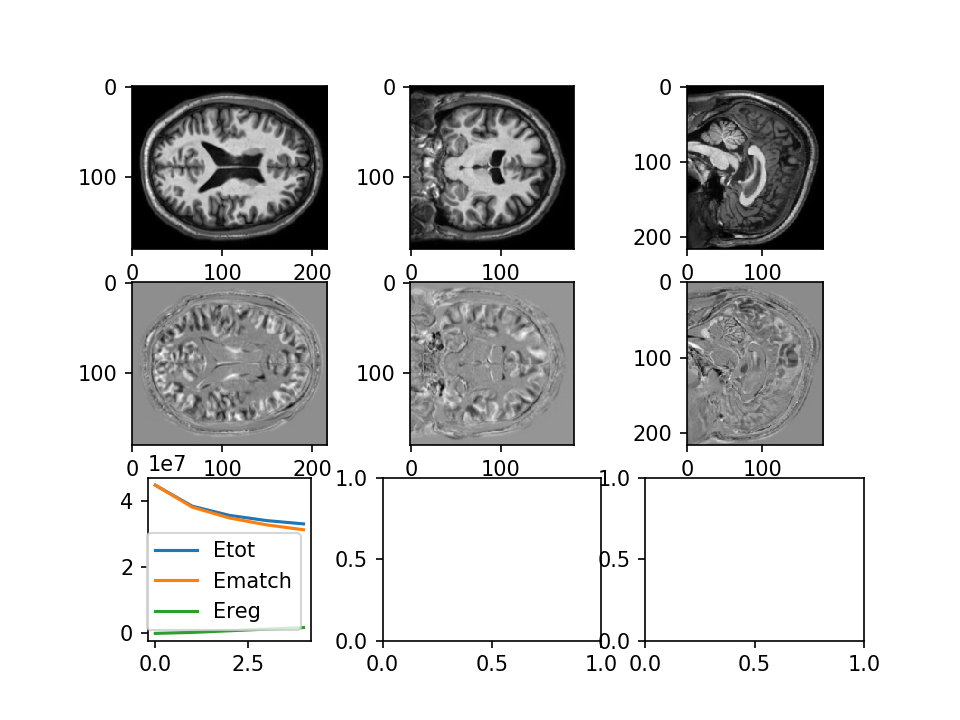

0.0
0.0
59261.1458727586
296305.729354663
160857.85858368006
788530.1980321801
266193.5215811322
1290312.954306997
365770.667808587
1761905.041778617


In [30]:
EMall = []
ERall = []
Eall = []
f,ax = plt.subplots(3,3)

for i in range(niter):
    # take a step of gradient descent
    vt0,vt1,vt2,Id,lambda1,EM,ER,E,ER0 = one_step(vt0,vt1,vt2)
    print(ER0)
    print(ER)
    draw_slices(x, Id, ax[0], cmap='gray', aspect='equal')
    draw_slices(x, lambda1, ax[1], cmap='gray', aspect='equal')

    EMall.append(EM)
    ERall.append(ER)
    Eall.append(E)
    ax[2][0].cla()
    ax[2][0].plot(list(zip(Eall,EMall,ERall)))
    xlim = ax[2][0].get_xlim()
    ylim = ax[2][0].get_ylim()
    ax[2][0].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    ax[2][0].legend(['Etot','Ematch','Ereg'])

    f.canvas.draw()
    f.savefig('lddmm3d_numpy_example_iteration_{:03d}.png'.format(i))
    
    